In [1]:
from facet_ml.classification import cnn
from torchvision.models import resnet152
import torch
from facet_ml.segmentation.segmenter import ImageSegmenter

device ="cuda"

In [2]:
## Load model
model  = cnn.load_model("resnet152_trained_Best.pth",resnet152)

## Load an ImageSegmenter
img_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Training\4 nM 5.bmp"
img_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Training\39.5 hold 1.bmp"
IS = ImageSegmenter(img_path,segmenter="segment_anything")


In [3]:
# ## Using the model, get the predicted label for each image segmenter
# for _,row in IS.df.iterrows():
#     region = row.Region
#     img = IS._grab_region(IS.image_cropped,region,0,5)
#     img_tensor = cnn.get_transform(train=False,)().forward(img)
#     img_tensor = img_tensor.reshape()
#     model(img_tensor)

In [4]:
dataset = cnn.ColloidalDataset.from_image_segmenter(IS)
dataset.transforms = cnn.get_transform(train=False)()

C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:672: RuntimeWarning: divide by zero encountered in divide
  clusters["major_axis_length"] / clusters["minor_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:672: RuntimeWarning: invalid value encountered in divide
  clusters["major_axis_length"] / clusters["minor_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:675: RuntimeWarning: invalid value encountered in divide
  clusters["perimeter"] / clusters["major_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:678: RuntimeWarning: divide by zero encountered in divide
  clusters["perimeter"] / clusters["minor_axis_length"]
C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\facet_ml\segmentation\segmenter.py:678: RuntimeWarning: invalid value encountered in 

In [5]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=16,
                                         num_workers = 4)
all_predictions = []
for inputs, labels in dataloader:
    inputs.to(device)
    labels.to(device)
    with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_predictions.extend(preds.cpu().numpy())

In [6]:
IS.df.Labels = [cnn.INT_TO_LABEL[L] for L in all_predictions]

In [7]:
all_predictions
IS.df.Labels

0       I
180     I
181     I
182     B
183     C
       ..
92      B
91      C
90      C
96      B
284    MC
Name: Labels, Length: 285, dtype: object

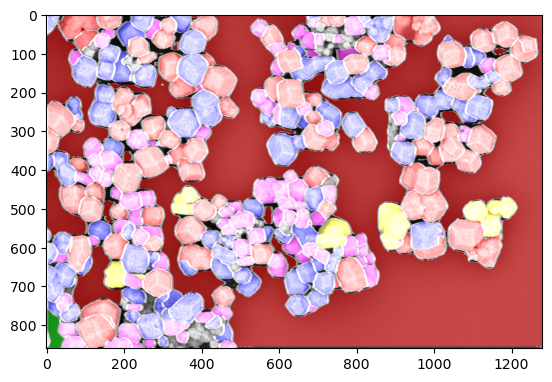

In [8]:
## Import colorization
from facet_ml.classification.model_using import visualize_labels
import numpy as np
color_dict: dict = { 
    "C": np.array([0, 0, 255]),
    "MC": np.array([255, 255, 0]),
    "I": np.array([255, 0, 0]),
    "PS": np.array([0, 255, 0]) 
    }
color_img = visualize_labels(IS, df=IS.df,color_dict=color_dict)

import matplotlib.pyplot as plt

plt.imshow(color_img)

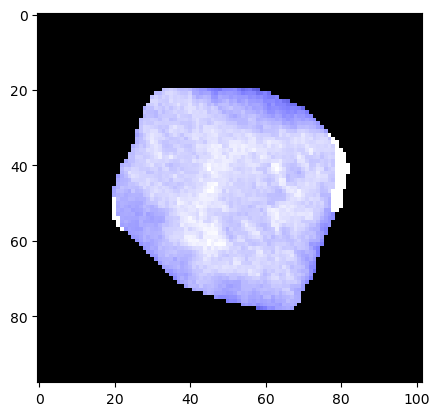

In [18]:
plt.imshow(IS._grab_region(color_img,8,0))

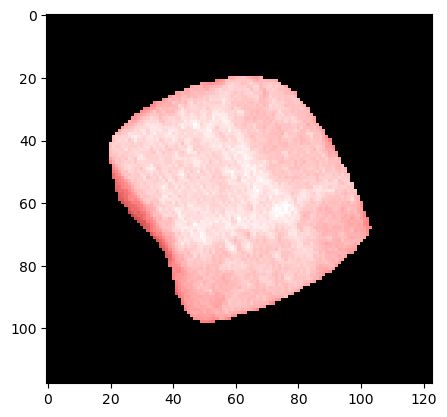

In [19]:
plt.imshow(IS._grab_region(color_img,6,0))

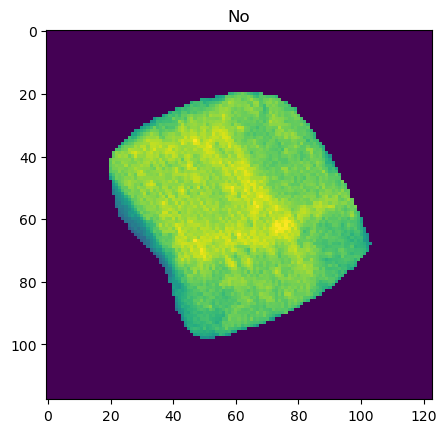

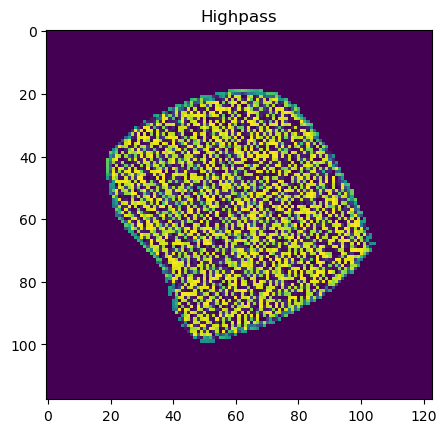

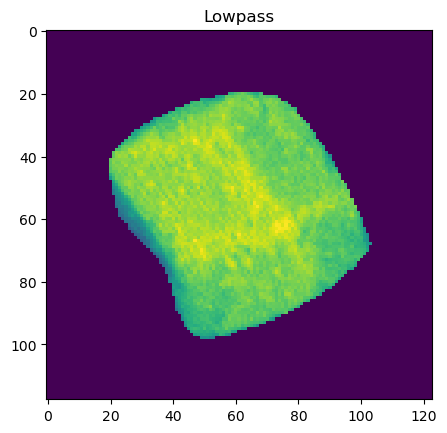

In [26]:
from scipy.ndimage import gaussian_filter, laplace

filter_tuple = (
    ("No",None,{}),
    ("Highpass",laplace,{}),
    ("Lowpass",gaussian_filter,{"sigma":0.1})
)
for label, func, kwargs in filter_tuple:
    img_base = IS._grab_region(IS.image_cropped,6,0)
    if func is not None:
        img = func(img_base, **kwargs)
    else:
        img = img_base
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(label)
    

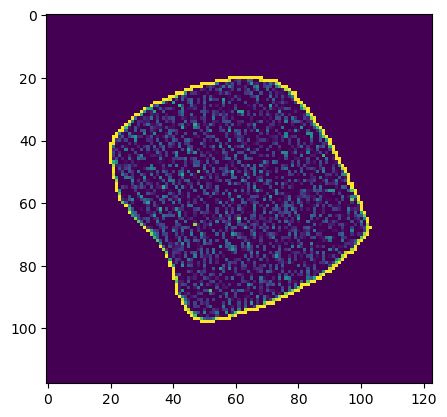

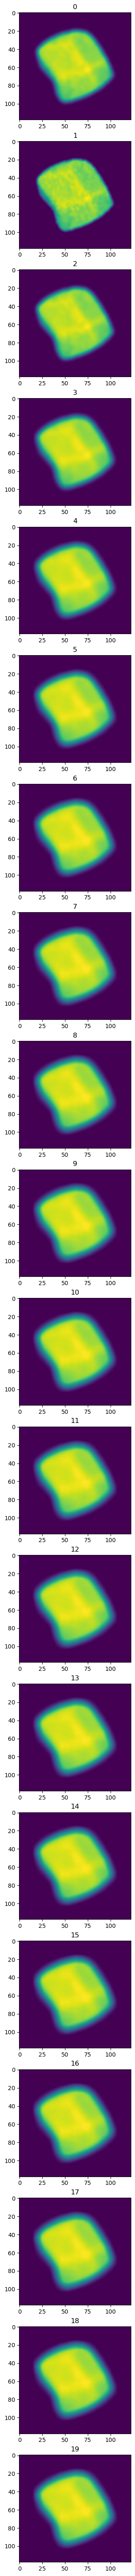

In [37]:
import cv2
highpass_kernel = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])

img = cv2.filter2D(img_base,-1,highpass_kernel)
plt.imshow(img)

sigma_list=list(range(20))
fig,axes = plt.subplots(nrows=len(sigma_list),figsize=(4,len(sigma_list)*4))
for sigma in sigma_list:
    ax = axes[sigma]
    img = cv2.GaussianBlur(img_base,(11,11),sigmaX=sigma,sigmaY=sigma)
    ax.imshow(img) 
    ax.set_title(sigma)